In [396]:
# Source: https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

Although, examples are using scalars instead of tensors (arrays of scalars), the underlying math is not changed, use of tensors is only really important to leverage computers parallel processing.

In [397]:
# Class which basically do all mathematical expressions, but also keeps a history of the operations
class Value:
    def __init__(self, value, _children=(), _op=''):
        self.value = value
        self._children = _children
        self._op = _op
        self.grad = 0.0 # The derivative of final output with respect to this value, the value will be set during back propagation
        self._backward = lambda: None # The function to calculate the gradients

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value + other.value, (self, other), '+')
        
        # Derivative during sum operation is 1.0 for both inputs
        def _backward():
            # Note: We are summing (and not just setting) the grads in case value is used more than once (multivariable chain rule)
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    # To support int + Value
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value * other.value, (self, other), '*')
        
        # Derivative during multiplication operation is the other value for the first input and the first value for the second input
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward
        
        return out
    
    # To support int * Value
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, power):
        assert isinstance(power, (int, float)), 'Power must be a number'
        out = Value(self.value ** power, (self,), f'**{power}')
        
        # Derivative during power operation is the power * value ^ (power - 1)
        def _backward():
            self.grad += power * self.value ** (power - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1.0
    
    def __repr__(self):
        return f'Value({self.value})'
    
    # We will use hyperbolic tangent as the activation function later for neuron
    def tanh(self):
        # It can be actually written with the use of more atomic operations, but for simplicity we will just define it like that
        out = Value(math.tanh(self.value), (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - math.tanh(self.value) ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    # Automatic back propagation, will be only called on the final output
    def backward(self):
        # Sort all node sin topological order (thus we are sure that all outputs' grads are calculated before the inputs)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0 # Base case
        for v in reversed(topo):
            v._backward()

In [398]:
# Use case example
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a * b 
d = e + c
f = Value(-2.0)
L = d * f
L # Our loss function

Value(-8.0)

In [399]:
# Manual back propagation (calculating the gradients)
L.grad = 1.0 # The derivative of the loss function with respect to itself is 1 (can be proven from the derivative definition)

d.grad = f.value #  dL / dd = d (d * f) / dd = f (derivative of mul, f is constant here)
f.grad = d.value #  dL / df = d (d * f) / df = d (derivative of mul, d is constant here)

e.grad = f.value #  dL / de = (dL / dd) * (dd / de) = f * 1 (chain rule, derivative of sum)
c.grad = f.value #  dL / dc = (dL / dd) * (dd / dc) = f * 1 (chain rule, derivative of sum)

a.grad = b.value * f.value # dL / da = (dL / de) * (de / da) = f * b (chain rule, derivative of mul)
b.grad = a.value * f.value # dL / db = (dL / de) * (de / db) = f * a (chain rule, derivative of mul)

print(a.grad, b.grad, c.grad, e.grad, d.grad, f.grad, L.grad)

6.0 -4.0 -2.0 -2.0 -2.0 4.0 1.0


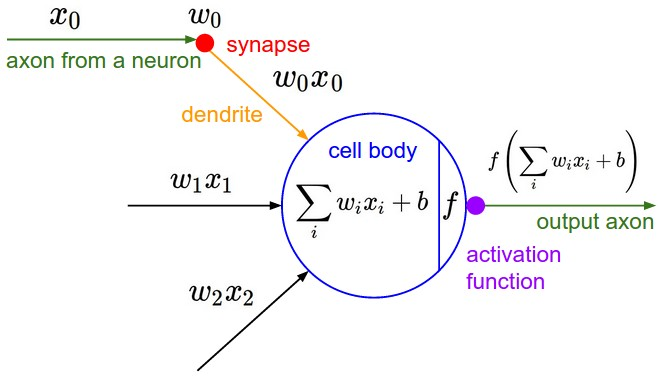

In [405]:
# Let's build a framework for automatic back propagation, for this we would need a concept of neuron
Image(filename='./mlp-basics/images/neuron_model.jpeg') 

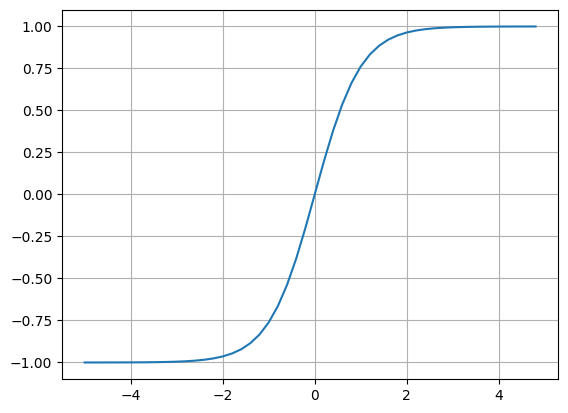

In [406]:
# We will use hyperbolic tangent as the activation function, because it is smooth and its derivative is easy to calculate (1 - tanh^2)
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [407]:
# Example of neuron with 2 inputs
x1 = Value(2.0)
x2 = Value(0.0)
# Weights
w1 = Value(-3.0)
w2 = Value(1.0)
# Bias
b = Value(6.88137358701953432)
# Output
n = w1 * x1 + w2 * x2 + b
o = n.tanh()
o

Value(0.7071067811865431)

In [408]:
# Automatic back propagation        
o.backward()
print(w1.grad, w2.grad, b.grad, x1.grad, x2.grad)

1.0000000000000124 0.0 0.5000000000000062 -1.5000000000000187 0.5000000000000062


In [409]:
# The same thing but with the use of Pytorch
import torch

# double: float32 -> float64
x1 = torch.tensor([2.0], requires_grad=True).double()
x2 = torch.tensor([0.0], requires_grad=True).double()
w1 = torch.tensor([-3.0], requires_grad=True).double()
w2 = torch.tensor([1.0], requires_grad=True).double()
b = torch.tensor([6.88137358701953432], requires_grad=True).double()
n = w1 * x1 + w2 * x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.7071066904050358


In [410]:
class Neuron:
    # nin - number of inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)]) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [411]:
# Example of neuron with 2 inputs
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(-0.9409730704699937)

In [412]:
# Let's build a layer of neurons now (just a list of neurons)
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

In [413]:
# Example of layer with 2 neurons
x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(-0.9750209949049937),
 Value(0.9267751596477609),
 Value(0.6029568140043465)]

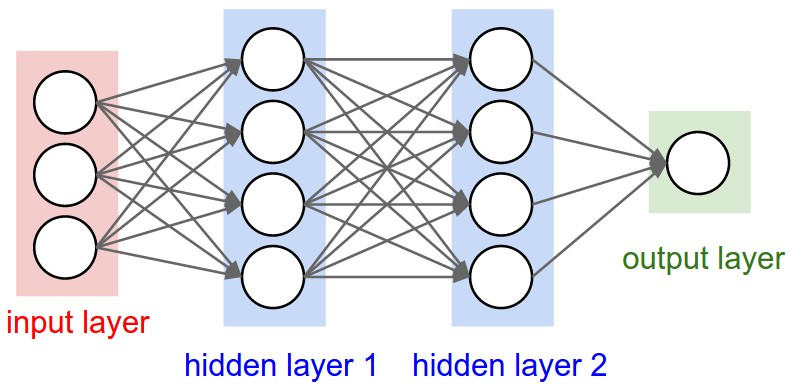

In [414]:
# Now let's build a neural (multi-layer perceptron) network (just a list of layers) form this picture
Image(filename='./mlp-basics/images/neural_net.jpeg') 

In [415]:
class MLP:
    def __init__(self, nin, nouts):
       sizes = [nin] + nouts
       self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [416]:
# Example of MLP with 3 inputs, 2 hidden layers with 4 neurons each and 1 output
n = MLP(3, [4, 4, 1])
len(n.parameters())

41

In [417]:
# Training the network
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [418]:
for k in range(100):
    # Forward pass
    ypred = [n(x) for x in xs]
    # The number that measures the total performance of neural network - loss
    # To calculate loss we will use mean squared error, we square it to make it always positive despite the sign of the error
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]) / len(ys)
    
    # Backward pass
    # Now we back propagate the loss, which will calculate the gradients of the weights and biases,
    # it has all the information about all the operations that were done to calculate the loss: 4 forward passes and the error calculation itself.
    # Thus, the gradients that are calculated are the gradients of the loss with respect to all the weights and biases.
    for p in n.parameters():
        # We need to reset the gradients, because otherwise we will accumulate them
        p.grad = 0.0
    loss.backward()

    # Update
    # We can leverage this information to minimise the loss by changing the weights and biases in the opposite direction of the gradients 
    # (We can think of gradients as vectors pointing in the direction of increase of loss).
    learning_rate = 0.05
    for p in n.parameters():
        p.value -= learning_rate * p.grad
    
    print(k, loss.value)

0 0.7366191968166151
1 0.6101698969368743
2 0.5118676825736378
3 0.4345457754558485
4 0.372718136140963
5 0.32248144679644797
6 0.28113191878418364
7 0.2467635855118766
8 0.21798126152309494
9 0.19372473271495677
10 0.17316561672554864
11 0.15564517242378434
12 0.1406341280131757
13 0.12770462814078246
14 0.11650938460825855
15 0.1067655636443458
16 0.09824207806539059
17 0.09074947488823454
18 0.08413186235928605
19 0.07826045936421121
20 0.07302843955721525
21 0.0683468080966125
22 0.0641411006021599
23 0.06034873590762489
24 0.05691688833798775
25 0.05380077288730988
26 0.050962258872737747
27 0.04836874533336292
28 0.04599224546115212
29 0.04380863841124352
30 0.04179705554165118
31 0.03993937497112943
32 0.03821980371658465
33 0.03662453089500439
34 0.03514143879960482
35 0.033759861282034634
36 0.032470380945283164
37 0.03126465829484617
38 0.030135287301630207
39 0.02907567287133398
40 0.028079926547929755
41 0.027142777447269506
42 0.02625949595503052
43 0.025425828158021413
44